In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import warnings
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
from matplotlib.cm import Paired
carac = pd.read_csv('./carcteristiques-2022.csv', sep=";")
usagers = pd.read_csv('./usagers-2022.csv', sep=";")

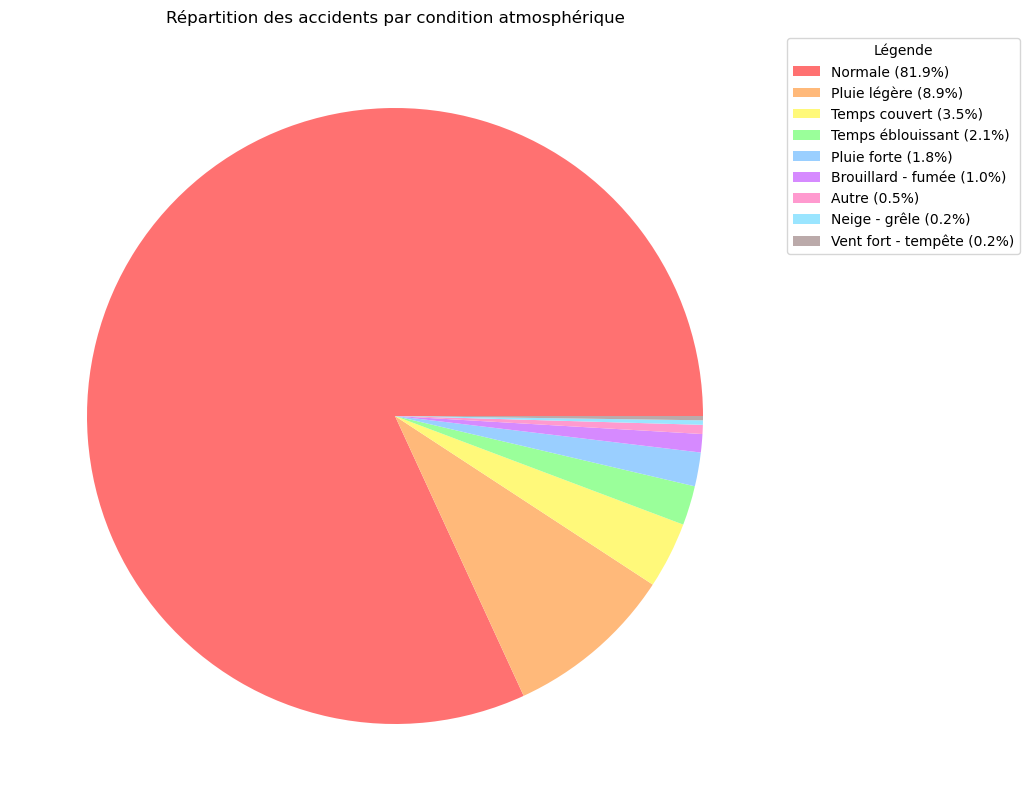

In [2]:
plt.figure(figsize=(10, 10))

conditions_atmospheriques = {
    -1: "Non renseigné",
    1: "Normale", 
    2: "Pluie légère", 
    3: "Pluie forte", 
    4: "Neige - grêle", 
    5: "Brouillard - fumée", 
    6: "Vent fort - tempête", 
    7: "Temps éblouissant", 
    8: "Temps couvert", 
    9: "Autre"
}

colors_hex = [
    "#FF7171",  
    "#FFB97A",  
    "#FFF97A",  
    "#9AFF9A",  
    "#9ACFFF",  
    "#D68AFF",  
    "#FF9ACF",  
    "#9AE5FF",  
    "#BBAAAA"
]

carac["atm_phrase"] = carac["atm"].replace(conditions_atmospheriques)
nombre_accidents_par_atm = carac["atm_phrase"].value_counts()
nombre_accidents_par_atm = nombre_accidents_par_atm[nombre_accidents_par_atm.index != "Non renseigné"]

plt.pie(nombre_accidents_par_atm, labels=None, colors=colors_hex)

plt.title("Répartition des accidents par condition atmosphérique")

legend_labels = [f'{label} ({value / sum(nombre_accidents_par_atm) * 100:.1f}%)' for label, value in nombre_accidents_par_atm.items()]
plt.legend(title="Légende", labels=legend_labels, bbox_to_anchor=(1, 1), loc="upper left")

plt.savefig("./results/condition_atm_camembert.png", bbox_inches='tight', pad_inches=0.1)

plt.show()

<Figure size 1000x600 with 0 Axes>

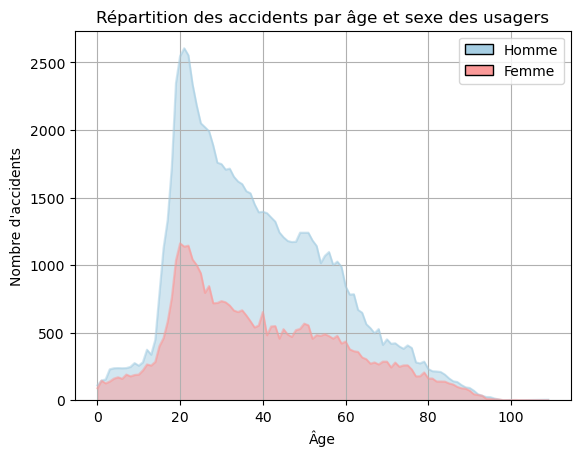

In [3]:
merged_data = pd.merge(carac, usagers, left_on="Accident_Id", right_on="Num_Acc")

merged_data['Age'] = merged_data['an'] - merged_data['an_nais']

merged_data = merged_data[merged_data['sexe'] != -1]

accidents_by_age_sex = merged_data.groupby(['Age', 'sexe']).size().unstack(fill_value=0)

colors = [Paired.colors[0], Paired.colors[4]]

plt.figure(figsize=(10, 6))
accidents_by_age_sex.plot.area(color=colors, stacked=False)  

plt.xlabel('Âge')
plt.ylabel('Nombre d\'accidents')
plt.title('Répartition des accidents par âge et sexe des usagers')

handles = [plt.Rectangle((0,0),1,1, color=colors[i], ec="k") for i in range(2)]
labels = ['Homme', 'Femme']

plt.legend(handles, labels)

plt.grid(True)
plt.savefig("./results/age_sexe.png", bbox_inches='tight', pad_inches=0.1)

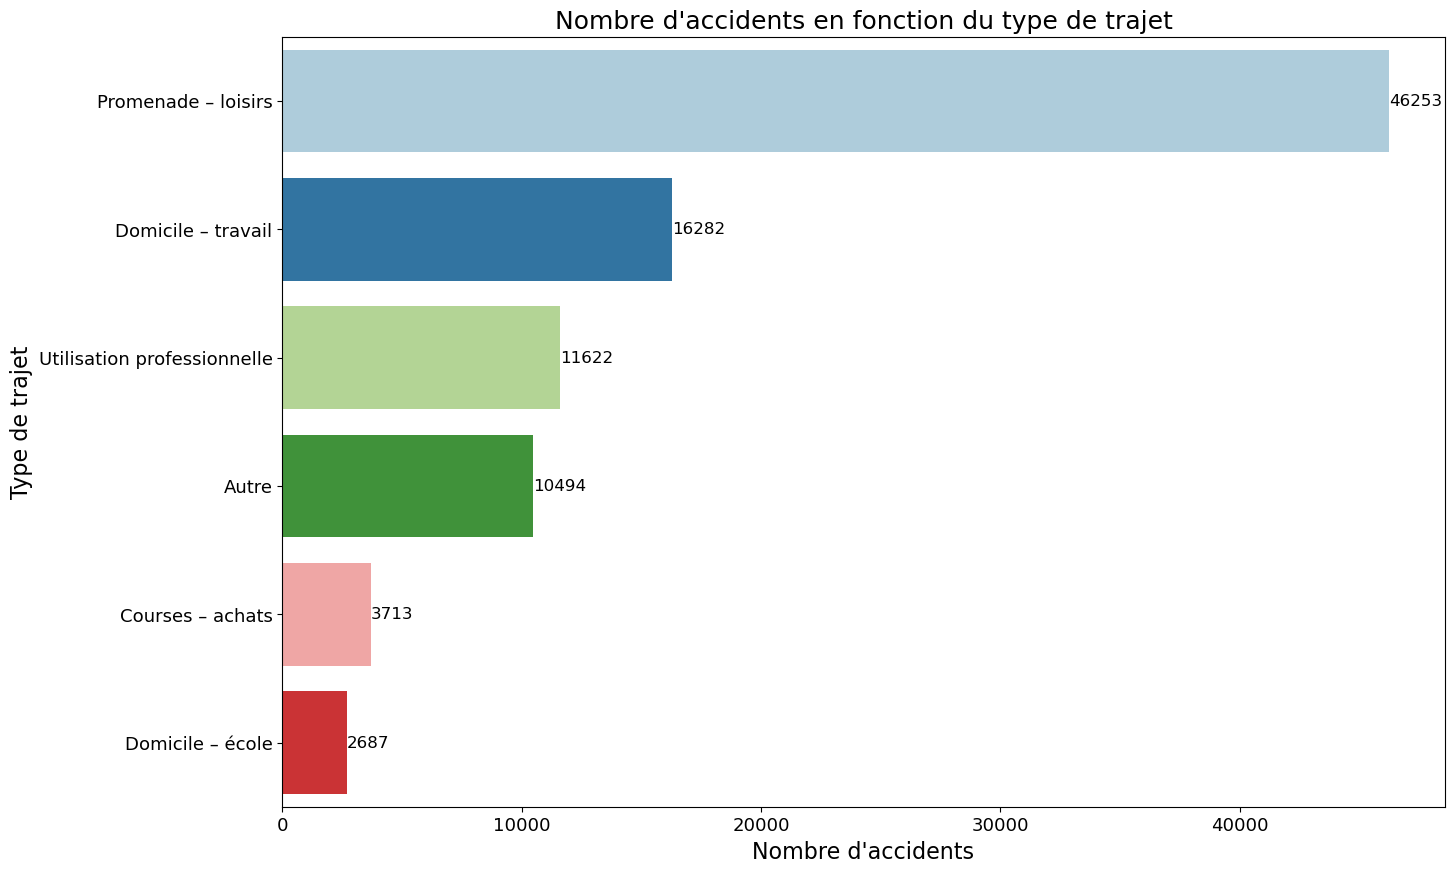

In [4]:
warnings.filterwarnings("ignore")
usagers_filtres = usagers[usagers['trajet'] >= 1]

usagers_trajets = {
    -1: "Non renseigné",
    0: "Non renseigné",
    1: "Domicile – travail",
    2: "Domicile – école",
    3: "Courses – achats",
    4: "Utilisation professionnelle",
    5: "Promenade – loisirs",
    9: "Autre"
}

usagers_filtres["trajet_type"] = usagers_filtres["trajet"].replace(usagers_trajets)

nombre_accidents = usagers_filtres.groupby("trajet_type").size().reset_index(name='nombre_accidents')

nombre_accidents = nombre_accidents.sort_values(by='nombre_accidents', ascending=False)

plt.figure(figsize=(15, 10))
ax = sns.barplot(y="trajet_type", x="nombre_accidents", data=nombre_accidents, palette="Paired")
plt.ylabel("Type de trajet", fontsize=16)  
plt.xlabel("Nombre d'accidents", fontsize=16)  
plt.title("Nombre d'accidents en fonction du type de trajet", fontsize=18) 
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

bars = ax.patches

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, int(width), ha='left', va='center', color='black', fontsize=12)

plt.savefig("./results/trajet2.png", bbox_inches='tight', pad_inches=0.1)
plt.show()


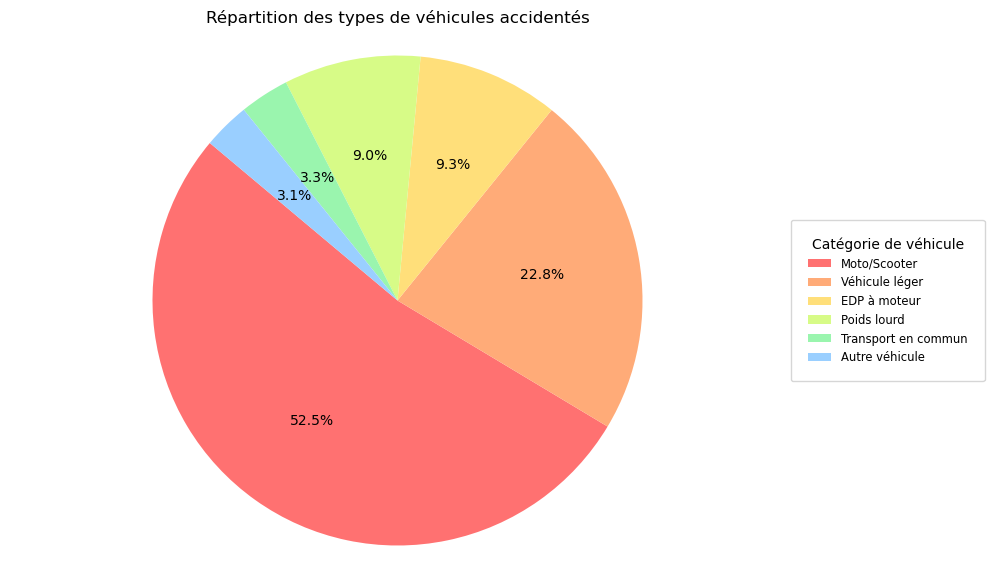

In [5]:
data = pd.read_csv("vehicules-2022.csv", delimiter=";")

categories = {
    '00': 'Indéterminable',
    '01': 'Véhicule léger',  # Regroupement des véhicules légers et des voiturettes
    '02': 'Véhicule léger',  # Regroupement des véhicules légers et des cyclomoteurs
    '03': 'Véhicule léger',  # Regroupement des véhicules légers et des voiturettes
    '04': 'Véhicule léger',  # Regroupement des véhicules légers et des scooters immatriculés
    '05': 'Moto/Scooter',    # Regroupement des motos et des scooters
    '06': 'Moto/Scooter',    # Regroupement des side-cars avec les motos/scooters
    '30': 'Moto/Scooter',    # Regroupement des scooters <50 cm3 avec les motos/scooters
    '31': 'Moto/Scooter',    # Regroupement des motos entre 50 et 125 cm3 avec les motos/scooters
    '32': 'Moto/Scooter',    # Regroupement des scooters entre 50 et 125 cm3 avec les motos/scooters
    '33': 'Moto/Scooter',    # Regroupement des motos >125 cm3 avec les motos/scooters
    '34': 'Moto/Scooter',    # Regroupement des scooters >125 cm3 avec les motos/scooters
    '35': 'Moto/Scooter',    # Regroupement des quads légers avec les motos/scooters
    '36': 'Moto/Scooter',    # Regroupement des quads lourds avec les motos/scooters
    '41': 'Moto/Scooter',    # Regroupement des 3RM <= 50 cm3 avec les motos/scooters
    '42': 'Moto/Scooter',    # Regroupement des 3RM entre 50 et 125 cm3 avec les motos/scooters
    '43': 'Moto/Scooter',    # Regroupement des 3RM > 125 cm3 avec les motos/scooters
    '07': 'Véhicule léger',  # Regroupement des véhicules légers et des véhicules utilitaires
    '08': 'Véhicule léger',  # Regroupement des véhicules légers et des véhicules utilitaires
    '09': 'Véhicule léger',  # Regroupement des véhicules légers et des véhicules utilitaires
    '10': 'Véhicule léger',  # Regroupement des véhicules légers et des véhicules utilitaires
    '11': 'Véhicule léger',  # Regroupement des véhicules légers et des véhicules utilitaires
    '12': 'Véhicule léger',  # Regroupement des véhicules légers et des véhicules utilitaires
    '13': 'Poids lourd',     # Regroupement de tous les poids lourds
    '14': 'Poids lourd',     # Regroupement de tous les poids lourds
    '15': 'Poids lourd',     # Regroupement de tous les poids lourds
    '16': 'Poids lourd',     # Regroupement de tous les poids lourds et tracteurs routiers
    '17': 'Poids lourd',     # Regroupement de tous les poids lourds et tracteurs routiers
    '18': 'Transport en commun',  # Regroupement de tous les transports en commun
    '19': 'Transport en commun',  # Regroupement de tous les transports en commun
    '20': 'Autre véhicule',       # Regroupement des tracteurs agricoles, des engins spéciaux et des EDP sans moteur
    '21': 'Autre véhicule',       # Regroupement des tracteurs agricoles, des engins spéciaux et des EDP sans moteur
    '37': 'Transport en commun',  # Regroupement de tous les transports en commun
    '38': 'Transport en commun',  # Regroupement de tous les transports en commun
    '39': 'Transport en commun',  # Regroupement de tous les transports en commun
    '40': 'Transport en commun',  # Regroupement de tous les transports en commun
    '50': 'EDP à moteur',         # Regroupement des EDP à moteur et des VAE
    '60': 'Autre véhicule',       # Regroupement des tracteurs agricoles, des engins spéciaux et des EDP sans moteur
    '80': 'EDP à moteur',         # Regroupement des EDP à moteur et des VAE
    '99': 'Autre véhicule'        # Regroupement des tracteurs agricoles, des engins spéciaux et des EDP sans moteur
}

data['catv'] = data['catv'].astype(str).map(categories)

# Calcul du nombre de véhicules par catégorie
vehicle_counts = data['catv'].value_counts()

# Définir des couleurs en utilisant des codes hexadécimaux
colors_hex = [
    "#FF7171",  # Rouge pastel
    "#FFB97A",  # Orange pastel
    "#FFF97A",  # Jaune pastel
    "#9AFF9A",  # Vert pastel
    "#9ACFFF"   # Bleu pastel
]

# Convertir les codes hexadécimaux en valeurs RVB
colors_rgb = [tuple(int(color[i:i+2], 16) / 255 for i in (1, 3, 5)) for color in colors_hex]

# Création de la colormap
cmap_name = 'pastel_colors'
cm = LinearSegmentedColormap.from_list(cmap_name, colors_rgb, N=len(vehicle_counts))

# Création du diagramme camembert
plt.figure(figsize=(10, 7))
plt.pie(vehicle_counts, labels=None, autopct='%1.1f%%', startangle=140, colors=cm(np.linspace(0, 1, len(vehicle_counts))))
plt.axis('equal')
plt.title('Répartition des types de véhicules accidentés')

# Création de la légende avec décalage vers la droite et bordures plus épaisses
plt.legend(vehicle_counts.index, title="Catégorie de véhicule", loc="center left", bbox_to_anchor=(1, 0.5), borderpad=1.5, fontsize="small")
plt.show()

<Figure size 2000x1000 with 0 Axes>

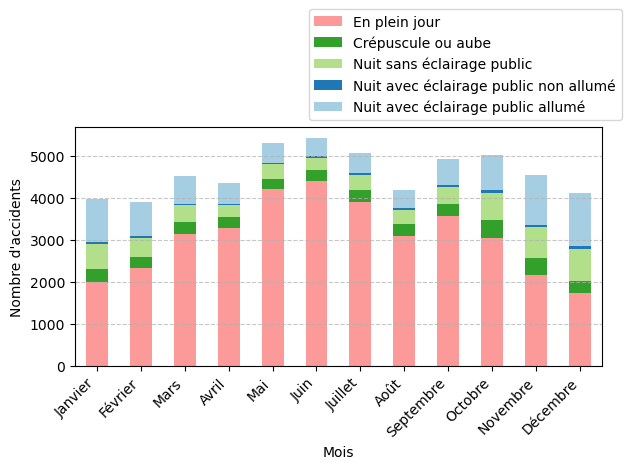

In [6]:
cara = pd.read_csv("carcteristiques-2022.csv", delimiter=";")
cara['mois'] = pd.to_numeric(cara['mois'])
mois_mapping = {
    1: "Janvier",
    2: "Février",
    3: "Mars",
    4: "Avril",
    5: "Mai",
    6: "Juin",
    7: "Juillet",
    8: "Août",
    9: "Septembre",
    10: "Octobre",
    11: "Novembre",
    12: "Décembre"
}

cara['mois'] = cara['mois'].map(mois_mapping)
donnees = cara[['mois', 'lum']]

# Créer la table pivot
pivot_table = donnees.pivot_table(index='mois', columns='lum', aggfunc=len, fill_value=0)

# Afficher la table pivot
donnees_mois_lum = pd.DataFrame(pivot_table)
donnees_mois_lum.drop(columns=[-1], inplace=True)
mois_order = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
donnees_mois_lum = donnees_mois_lum.reindex(mois_order)

# Définir l'ordre inverse des couleurs dans la palette
custom_palette = sns.color_palette("Paired", n_colors=len(donnees_mois_lum.columns))[::-1]

plt.figure(figsize=(20, 10))
# Modifier les noms des légendes
legend_labels = {
    1: 'En plein jour',
    2: 'Crépuscule ou aube',
    3: 'Nuit sans éclairage public',
    4: 'Nuit avec éclairage public non allumé',
    5: 'Nuit avec éclairage public allumé'
}

# Afficher la légende avec les nouveaux noms
donnees_mois_lum.plot.bar(stacked=True, color=custom_palette)
# Afficher la légende avec les nouveaux noms
plt.legend(labels=legend_labels.values(), bbox_to_anchor=(1.05, 1), loc='lower right')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'accidents')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("./results/condition_lum.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

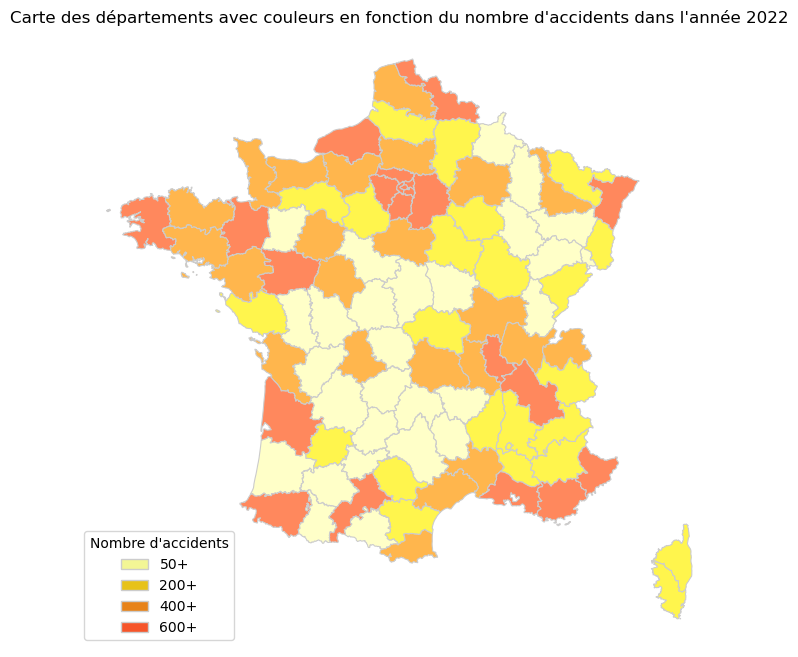

In [7]:
departements = gpd.read_file("departements.geojson")

# Calcul du nombre d'accidents par département
accidents_par_departement = carac.groupby('dep').size().reset_index(name='nombre_accidents')

# Fusion des données des départements avec les données d'accidents
departements_accidents = departements.merge(accidents_par_departement, left_on='code', right_on='dep')

# Définition des seuils et des couleurs
seuils = [50, 200, 400, 600]
couleurs = ['#f3f695', '#e7c21a', '#e7831a', '#f6552a', 'black']

# Attribution des couleurs aux départements en fonction du nombre d'accidents
couleurs_departements = []
for nombre_accidents in departements_accidents['nombre_accidents']:
    couleur = couleurs[0]  # Couleur par défaut
    for seuil, col in zip(seuils, couleurs):
        if nombre_accidents > seuil:
            couleur = col
    couleurs_departements.append(couleur)

# Luminosité des couleurs pour une meilleure visibilité
for i, couleur in enumerate(couleurs_departements):
    rgb = mcolors.to_rgb(couleur)
    couleur_claire = mcolors.rgb2hex([min(1, c + 0.2) for c in rgb])
    couleurs_departements[i] = couleur_claire

# Création de la carte
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
departements_accidents.plot(color=couleurs_departements, edgecolor='0.8', linewidth=0.8, ax=ax)

legend_elements = [Patch(facecolor=color, edgecolor='0.8', label=f'{seuil}+') for seuil, color in zip(seuils, couleurs)]
plt.legend(handles=legend_elements, title='Nombre d\'accidents', loc='lower left')

plt.title('Carte des départements avec couleurs en fonction du nombre d\'accidents dans l\'année 2022')
plt.axis('off')
plt.savefig("dep_accident.png")


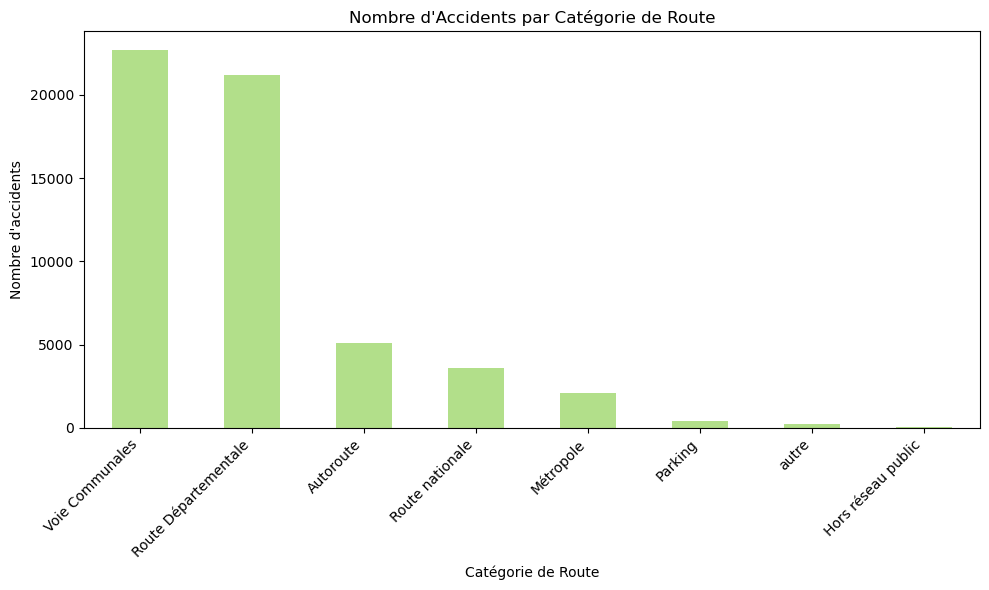

In [8]:
cat_route = {
    1: "Autoroute",
    2: "Route nationale",
    3: "Route Départementale",
    4: "Voie Communales",
    5: "Hors réseau public",
    6: "Parking",
    7: "Métropole",
    9: "autre"
}

donnees_accidents = pd.read_csv("lieux-2022.csv", delimiter=";")

accidents_par_categorie = donnees_accidents['catr'].map(cat_route).value_counts()

# Liste de couleurs hexadécimales pour chaque catégorie de route
couleurs = ['#b2df8a']

plt.figure(figsize=(10, 6))
accidents_par_categorie.plot(kind='bar', color=couleurs)  # Utilisation de la liste de couleurs

plt.title("Nombre d'Accidents par Catégorie de Route")
plt.xlabel('Catégorie de Route')
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=45, ha='right')  # Rotation du texte pour plus de lisibilité

plt.tight_layout()

plt.savefig("categorie de route.png")

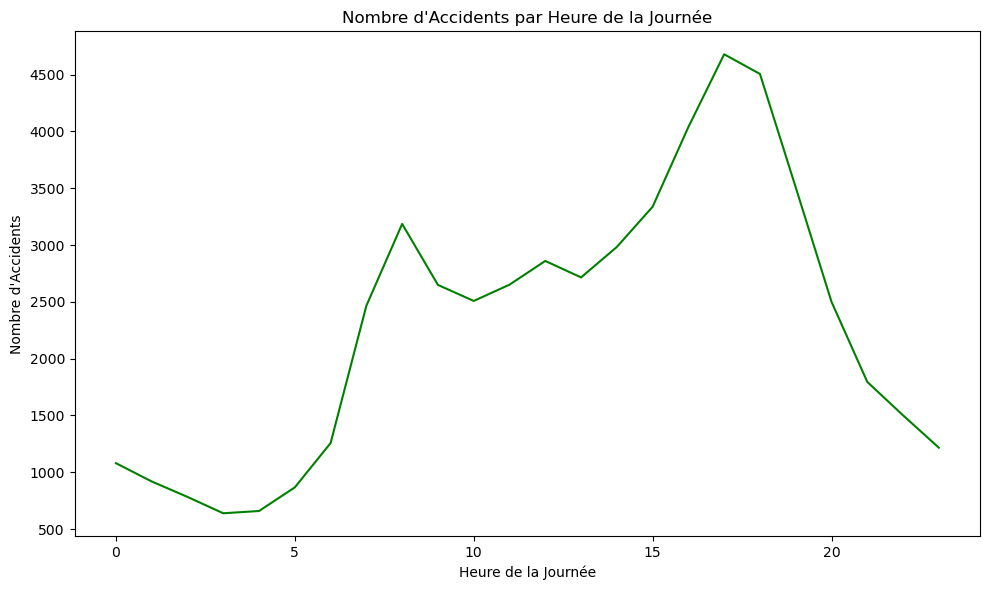

In [9]:
donnees_accidents = pd.read_csv("carcteristiques-2022.csv", delimiter=";")
donnees_accidents['heure'] = pd.to_datetime(donnees_accidents['hrmn'], format='%H:%M', errors='coerce').dt.hour
accidents_par_heure = donnees_accidents['heure'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(accidents_par_heure.index, accidents_par_heure.values, color='green')
plt.title("Nombre d'Accidents par Heure de la Journée")
plt.xlabel("Heure de la Journée")
plt.ylabel("Nombre d'Accidents")
plt.xticks(rotation=0)  
plt.savefig("ligne.png")
plt.tight_layout()
plt.show()

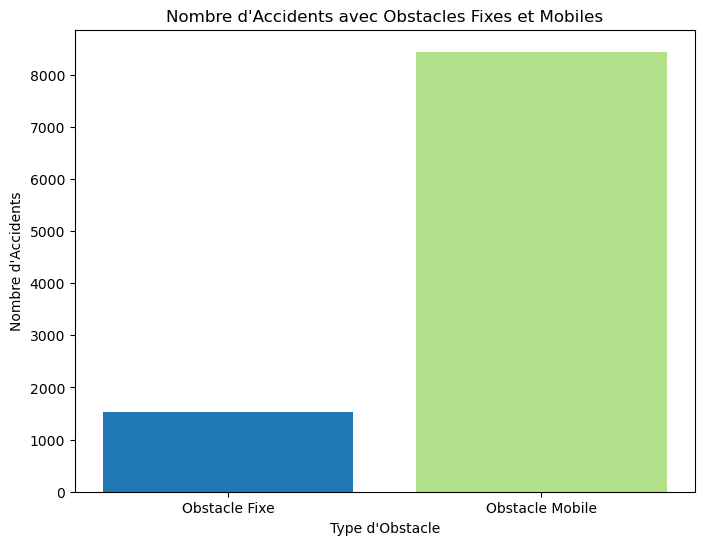

In [10]:
# Chargement des données des véhicules
donnees_vehicules = pd.read_csv("vehicules-2022.csv", delimiter=";")

# Supprimer les doublons dans la colonne 'Num_Acc'
donnees_vehicules = donnees_vehicules.drop_duplicates(subset=['Num_Acc'])

# Compter le nombre d'occurrences de 'obs' et 'obsm'
nombre_obs = donnees_vehicules['obs'].value_counts().get(1, 0)
nombre_obsm = donnees_vehicules['obsm'].value_counts().get(1, 0)

# Couleurs
couleur_obs = '#1f78b4'
couleur_obsm = '#b2df8a'

# Création du graphique à barres avec couleurs spécifiées
plt.figure(figsize=(8, 6))
plt.bar(['Obstacle Fixe', 'Obstacle Mobile'], [nombre_obs, nombre_obsm], color=[couleur_obs, couleur_obsm])

# Titre et étiquettes
plt.title("Nombre d'Accidents avec Obstacles Fixes et Mobiles")
plt.xlabel("Type d'Obstacle")
plt.ylabel("Nombre d'Accidents")
plt.savefig("obstacle.png")
plt.show()

In [14]:
# Charger le fichier CSV dans un DataFrame
cara = pd.read_csv("carcteristiques-2022.csv", delimiter=";")
usagers = pd.read_csv("usagers-2022.csv", delimiter=";")

resultats = []

# Parcourir les lignes de usagers
for index_usager, row_usager in usagers.iterrows():
    # Vérifier si la gravité est 2 ou 3
    if row_usager['grav'] in [2]:
        # Trouver les lignes correspondantes dans cara
        lignes_cara_similaires = cara[cara['Accident_Id'] == row_usager['Num_Acc']]
        # Parcourir les lignes correspondantes dans cara
        for index_cara, row_cara in lignes_cara_similaires.iterrows():
            # Ajouter les coordonnées à la liste de résultats
            resultats.append({'lat': row_cara['lat'], 'long': row_cara['long']})

# Créer un DataFrame à partir de la liste de résultats
resultats_df = pd.DataFrame(resultats)

# Afficher les résultats
print(resultats_df)

# Remplacer les virgules par des points dans les colonnes de latitude et de longitude
resultats_df['long'] = resultats_df['long'].str.replace(',', '.')
resultats_df['lat'] = resultats_df['lat'].str.replace(',', '.')

# Convertir les colonnes de latitude et de longitude en float
resultats_df['long'] = resultats_df['long'].astype(float)
resultats_df['lat'] = resultats_df['lat'].astype(float)

# Créer une carte centrée sur la France
m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

# Créer une HeatMap à partir des données de latitude et de longitude
heat_data = [[row['lat'], row['long']] for index, row in resultats_df.iterrows()]
HeatMap(heat_data, radius=18).add_to(m)

# Enregistrer la carte dans un fichier HTML
m.save("heatmap.html")

                  lat            long
0       46,1022300000    3,5027800000
1       49,6431298707    1,2667151729
2       49,6888370000    1,3520320000
3       49,1540190000    4,2083750000
4       49,1540190000    4,2083750000
...               ...             ...
3545    47,1352500000    2,1552140000
3546   -21,6590100000  165,5346000000
3547    42,3101650000    9,4785830000
3548    43,7531640000    5,2244760000
3549    46,2825320000    6,7328060000

[3550 rows x 2 columns]


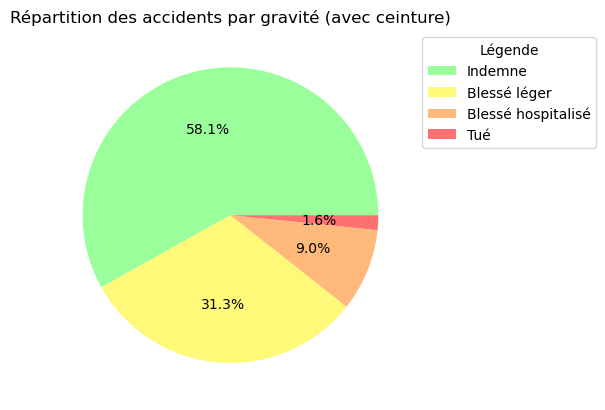

In [12]:
usagers_grav = {
    1: "Indemne",
    2: "Tué",
    3: "Blessé hospitalisé",
    4: "Blessé léger"
}

colors = ['#9AFF9A', '#FFF97A', '#FFB97A', '#FF7171']

usagers = pd.read_csv("usagers-2022.csv", delimiter=";")
usagers["grav_type"] = usagers["grav"].replace(usagers_grav)
usagers = usagers.loc[usagers["secu1"] == 1]

nombre_accidents_par_grav = usagers["grav_type"].value_counts()

plt.pie(nombre_accidents_par_grav, autopct='%1.1f%%', colors=colors)
plt.title("Répartition des accidents par gravité (avec ceinture)")
plt.legend(title="Légende", labels=nombre_accidents_par_grav.index, bbox_to_anchor=(1, 1), loc="upper left")
plt.savefig("results/ceinture.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

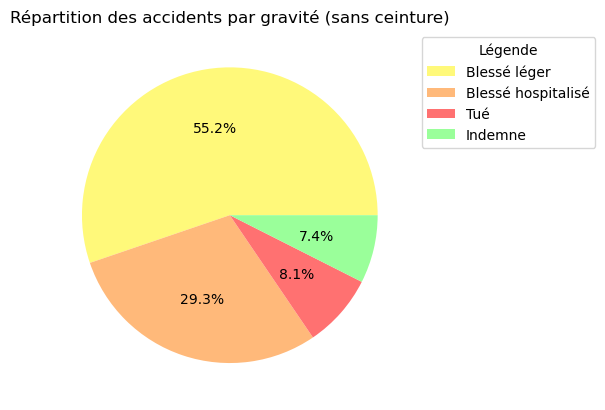

In [13]:
usagers_grav = {
    1: "Indemne",
    2: "Tué",
    3: "Blessé hospitalisé",
    4: "Blessé léger"
}

colors = ['#FFF97A', '#FFB97A', '#FF7171', '#9AFF9A']

usagers = pd.read_csv("usagers-2022.csv", delimiter=";")
usagers["grav_type"] = usagers["grav"].replace(usagers_grav)

usagers = usagers.loc[usagers["secu1"] == 0]

nombre_accidents_par_grav = usagers["grav_type"].value_counts()

plt.pie(nombre_accidents_par_grav, autopct='%1.1f%%', colors=colors)
plt.title("Répartition des accidents par gravité (sans ceinture)")
plt.legend(title="Légende", labels=nombre_accidents_par_grav.index, bbox_to_anchor=(1, 1), loc="upper left")
plt.savefig("results/sceinture.png", bbox_inches='tight', pad_inches=0.1)
plt.show()